<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-1/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Descargo el dataset

In [ ]:
!wget https://www.dropbox.com/s/zrl3tlz8ddajxgx/knows.zip?dl=0 -O data.zip
!unzip data.zip

# Reconocimiento facial: python + tensorflow + keras

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [73]:
DIR_KNOWNS = '2'
DIR_UNKNOWNS = 'unknowns'
DIR_RESULTS = 'results'

In [ ]:
# Leer primer modelo de red convolucional
!wget https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0 -O mobilenet_graph.pb

with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

In [14]:
# Imágen para cargar una imagen en un directorio y un nombre
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

In [15]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [16]:
# Dibujar bounding boxes
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

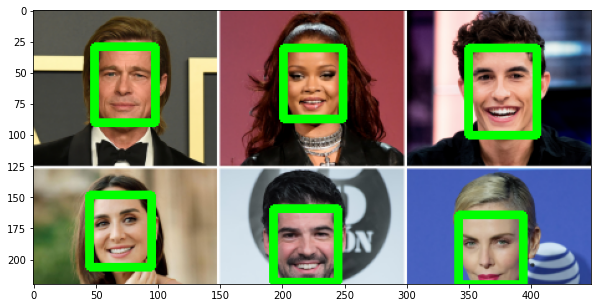

In [22]:
name = 'multiple.png'
image = load_image(DIR_UNKNOWNS,name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [23]:
# Extraer rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

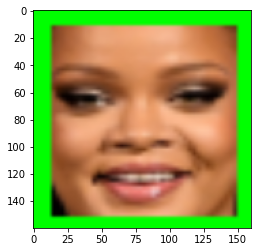

In [52]:
caras = extract_faces(image,bboxes)
plt.imshow(caras[1])


In [54]:
# FaceNet
!wget https://www.dropbox.com/s/z0o1of3580smtwr/facenet_keras.h5?dl=0 -O facenet_keras.h5

facenet = load_model('facenet_keras.h5')
print(facenet.input_shape)
print(facenet.output_shape)

--2021-05-13 13:54:56--  https://www.dropbox.com/s/z0o1of3580smtwr/facenet_keras.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/z0o1of3580smtwr/facenet_keras.h5 [following]
--2021-05-13 13:54:56--  https://www.dropbox.com/s/raw/z0o1of3580smtwr/facenet_keras.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18bb97da47e1471febf0fab8cf.dl.dropboxusercontent.com/cd/0/inline/BOYhnzM7xVyg4L7I7tKT1C3i-49iP-nyrWZ1dr6ptadHcSOcIPyPp5J9nx9VVKLtwczJPAkCsKDN2kpCf8znvUOkb3TnCNEi1KZZVmPdHntxe2tj6WGwQgNrHzWhaZbV4Tw8iRSnyXf6I_UhcMdiFI9H/file# [following]
--2021-05-13 13:54:56--  https://uc18bb97da47e1471febf0fab8cf.dl.dropboxusercontent.com/cd/0/inline/BOYhnzM7xVyg4L7I7tKT1C3i-49iP-nyrWZ1dr6ptadHcSOcIPyPp5J9nx9VVKLtwczJPAkCs

In [56]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [57]:
embedding = compute_embedding(facenet,faces[0])
print(embedding)

[[-0.2228742  -0.47523853  1.0986972  -1.497712    0.24111408 -2.3598971
   0.7207787  -1.7223426  -0.08958293 -1.1460758   0.74130654 -0.8431082
  -0.42923218 -0.92958593 -0.80795956  2.3239703  -0.85689473 -0.46542293
  -0.10152531 -1.212767   -0.15025266  1.2107149  -0.44329023  1.3687637
  -2.0128624  -0.7636142   0.61227524 -0.7899355  -0.08574523  0.55776834
  -0.1830683  -0.3304857   1.0407324   1.2753003  -0.5491439   1.9250472
   0.15979357 -1.3189731  -0.16610658  0.9248067   1.3391844  -1.4841765
   0.68472886 -0.657127    1.9198169  -0.40259674 -0.4528371   1.1014423
  -1.1333461   0.21455678 -0.89963174 -1.2274288  -1.6426      1.2035996
  -1.2784048   0.44722322 -1.560748    0.17667453  0.2634232  -0.27023926
  -0.43045974 -1.4063125  -0.7961061  -0.2022376  -1.3385088   1.8512661
   0.731379   -0.4086169  -0.94922775 -0.46882644 -0.4207236  -0.67816794
   2.4818401  -0.22796236 -0.8076687  -1.115826   -0.19385433  0.00514355
   0.26687536 -1.4339143  -1.3248714   0.75077

# Descarga dataset

In [1]:
!wget https://www.dropbox.com/s/icj8g7cu3krttge/2.zip?dl=0 -O knows.zip
!unzip knows.zip


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: 2/462695.jpg            
  inflating: 2/462696.jpg            
  inflating: 2/462697.jpg            
  inflating: 2/462698.jpg            
  inflating: 2/462699.jpg            
  inflating: 2/462700.jpg            
  inflating: 2/462717.jpg            
  inflating: 2/46272.jpg             
  inflating: 2/462724.jpg            
  inflating: 2/462725.jpg            
  inflating: 2/462726.jpg            
  inflating: 2/46273.jpg             
  inflating: 2/462731.jpg            
  inflating: 2/462734.jpg            
  inflating: 2/462736.jpg            
  inflating: 2/462737.jpg            
  inflating: 2/46274.jpg             
  inflating: 2/462743.jpg            
  inflating: 2/462746.jpg            
  inflating: 2/462747.jpg            
  inflating: 2/462748.jpg            
  inflating: 2/462750.jpg            
  inflating: 2/462751.jpg            
  inflating: 2/462753.jpg            
  inflating: 2/462754.jpg  

In [ ]:
# Embeddings referencia

known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir(DIR_KNOWNS):
    if name.endswith('.jpg'):
        try:
          cv2.cvtColor(cv2.imread(f'{DIR_KNOWNS}/{name}'), cv2.COLOR_BGR2RGB)
          bboxes = detect_faces(image)
          face = extract_faces(image,bboxes)
          if len(face)>0:
            known_embeddings.append(compute_embedding(facenet,face[0]))        
        except:
          print('Error: ' + name )
        
        
        

In [ ]:
known_embeddings.shape

In [ ]:
def compare_faces(embs_ref, emb_desc, umbral=11):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    return distancias, list(distancias<=umbral)

In [80]:
# Reconocimiento (????) de rostros desconocidos
print('Procesando imágenes desconocidas...')
for name in os.listdir(DIR_UNKNOWNS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_UNKNOWNS,name)
        bboxes = detect_faces(image)
        faces = extract_faces(image,bboxes)
        
        # Por cada rostro calcular embedding
        img_with_boxes = image.copy()
        for face, box in zip(faces,bboxes):
            emb = compute_embedding(facenet,face)
            
            _, reconocimiento = compare_faces(known_embeddings,emb)
            
            if any(reconocimiento):
                print('     match!')
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0))
            else:
                img_with_boxes = draw_box(img_with_boxes,box,(255,0,0))
            
        cv2.imwrite(f'{DIR_RESULTS}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
print('¡Fin!')                    
            
        
        
        

Procesando imágenes desconocidas...
¡Fin!
